<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>

# 09 Compute best-fit ellipsoid approximation of the whole fruit

We now go for macro modeling.

For each fruit, a point cloud, a collection of $(x,y,z)$ coordinates in the space, was defined by the centers of all its individual oil glands.
- We compute an ellipsoid that fits the best this point cloud
- To that end, we do just an ordinary least square fit to find the best coefficients of the respective quadratic equation that approximate most of the point cloud points.
- The algebraic-fit ellipsoid was adapted from [Li and Griffiths (2004)](https://doi.org/10.1109/GMAP.2004.1290055). 
- This produces a 10-dimensional vector that algebraically defines an ellipsoid. 
    - See [Panou et al. (2020)](https://doi.org/10.1515/jogs-2020-0105) on how to convert this vector into geometric parameters.

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SW01_CRC3030_12B-8-5_L02_frontal_ell_projection.jpg" style="width:500px">
        <p style="text-align:center;font-size:20px">Approximating a sweet orange</p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_CRC3289_12B-19-9_L02_frontal_ell_projection.jpg" alt = "barley" style="width:500px;"/>
        <p style="text-align:center;font-size:20px">Approximating a sour orange</p>
    </td>
  </tr>
</tbody>
</table>

In [1]:
import numpy as np
import pandas as pd
import glob
import os

import tifffile as tf
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import citrus_utils as vitaminC

### Define the appropriate base/root name and label name

- This is where having consistent file naming pays off

In [2]:
tissue_src = '../data/tissue/'
oil_src = '../data/oil/'
bnames = [os.path.split(x)[-1] for x in sorted(glob.glob(oil_src + 'WR*'))]
for i in range(len(bnames)):
    print(i, '\t', bnames[i])

0 	 WR05_CRC3605_18B-19-5


In [3]:
bname = bnames[0]
L = 3

lname = 'L{:02d}'.format(L)
rotateby = [2,1,0]

### Load voxel-size data

- The micron size of each voxel depends on the scanning parameters

In [4]:
voxel_filename = '../data/citrus_voxel_size.csv'
voxel_size = pd.read_csv(voxel_filename)
voxsize = (voxel_size.loc[voxel_size.ID == bname, 'voxel_size_microns'].values)[0]
print('Each voxel is of side', voxsize, 'microns')

Each voxel is of side 57.5 microns


## Load oil gland centers and align based on spine

- From the previous step, retrieve the `vh` rotation matrix to align the fruit
- The point cloud is made to have mean zero and it is scaled according to its voxel size
- The scale now should be in cm
- Plot 2D projections of the oil glands to make sure the fruit is standing upright after rotation

In [5]:
savefig= False
filename = tissue_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vh_alignment.csv'
vh = np.loadtxt(filename, delimiter = ',')
print(vh)

[[ 9.92111916e-01 -9.20178175e-02  8.51273630e-02]
 [-9.22832159e-02 -9.95732461e-01 -8.20533131e-04]
 [ 8.48395824e-02 -7.04176612e-03 -9.96369740e-01]]


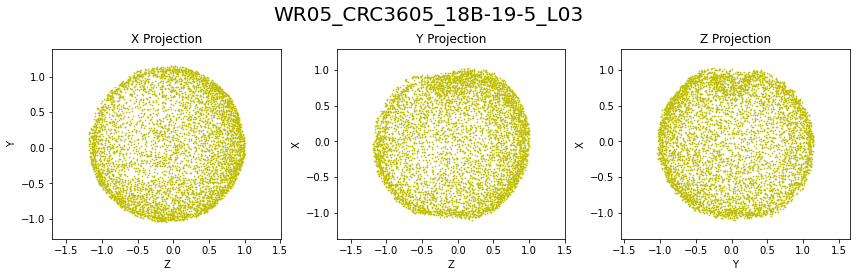

In [6]:
oil_dst = oil_src + bname + '/' + lname + '/'
filename = oil_dst + bname + '_' + lname + '_glands.csv'
glands = np.loadtxt(filename, delimiter=',', dtype=float)

glands = np.matmul(glands, np.transpose(vh))
centerby = np.mean(glands, axis = 0)
scaleby = 1e4/voxsize
glands = (glands - centerby)/scaleby

dst = oil_src + bname + '/'
vitaminC.plot_3Dprojections(glands, title=bname+'_'+lname, writefig=savefig, dst=dst)

# Compute the general conic parameters

Here we follow the algorithm laid out by [Li and Griffiths (2004)](https://doi.org/10.1109/GMAP.2004.1290055). 


A general quadratic surface is defined by the equation

$$\eqalignno{ & ax^{2}+by^{2}+cz^{2}+2fxy+2gyz+2hzy\ \ \ \ \ \ \ \ \ &\hbox{(1)}\cr &+2px+2qy+2rz+d=0.}$$

Let $$\rho = \frac{4J-I}{a^2 + b^2 + c^2},$$

$$\eqalignno{ &I = a+b+c &\hbox{(2)}\cr &J =ab+bc+ac-f^{2}-g^{2}-h^{2}&\hbox {(3)}\cr & K=\left[\matrix{ a & h & g \cr h & b & f \cr g & f & c }\right] &\hbox{(4)}}.$$

These values are invariant under rotation and translation and equation (1) represents an ellipsoid if $J > 0$ and $IK>0$.

With our observations $\{(x_i,y_i,z_i)\}_i$, we would ideally want a vector of parameters $(a,b,c,f,g,h,p,q,r,d)$ such that

$$
\begin{pmatrix}
x_1^2 & y_1^2 & z_1^2 & 2x_1y_1 & 2y_1z_1 & 2x_1z_1 & x_1 & y_1 & z_1 & 1\\
x_2^2 & y_2^2 & z_2^2 & 2x_2y_2 & 2y_2z_2 & 2x_2z_2 & x_2 & y_2 & z_2 & 1\\
\vdots& \vdots& \vdots& \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_n^2 & y_n^2 & z_n^2 & 2x_ny_n & 2y_nz_n & 2x_nz_n & x_n & y_n & z_n & 1
\end{pmatrix}
\begin{pmatrix}
a \\ b \\ \vdots \\ d
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 0 \\ \vdots \\ 0
\end{pmatrix}
$$
or
$$
\mathbf{D}\mathbf{v} = 0
$$

The solution to the system above can be obtained via Lagrange multipliers

$$\min_{\mathbf{v}\in\mathbb{R}^{10}}\left\|\mathbf{D}\mathbf{v}\right\|^2, \quad \mathrm{s.t.}\; kJ - I^2 = 1$$

If $k=4$, the resulting vector $\mathbf{v}$ is guaranteed to be an ellipsoid. 

- Experimental results suggest that the optimization problem also yields ellipsoids for higher $k$'s if there are enough sample points.

---

- This whole procedure yields a 10-dimensional vector $(a,b,c,f,g,h,p,q,r,1)$, which is then translated to geometric parameters as shown in [Panou et al. (2020)](https://doi.org/10.1515/jogs-2020-0105)

We obtain finally a `6 x 3` matrix with all the geometric parameters
```
[ x,y,z coordinates of ellipsoid center ]
[          semi-axes lengths            ]
[                 |                     ]
[   --  3 x 3 rotation matrix   --      ]
[                 |                     ]
[       x,y,z rotation angles           ]
```

In [15]:
np.vstack(tuple(ell_params.values())).shape

(6, 3)

In [7]:
bbox = (np.max(glands, axis=0) - np.min(glands, axis=0))*.5
guess = np.argsort(np.argsort(bbox))
print(bbox)
print(guess[rotateby])
bbox[rotateby]

[1.05911753 1.08946973 1.09470996]
[2 1 0]


array([1.09470996, 1.08946973, 1.05911753])

In [8]:
datapoints = glands.T

filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vox_v_ell.csv'
ell_v_params, flag = vitaminC.ell_algebraic_fit2(datapoints, k=4)
print(np.around(ell_v_params,3), '\n', flag, 'ellipsoid\n')
np.savetxt(filename, ell_v_params, delimiter=',')

filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vox_m_ell.csv'
ell_params = vitaminC.get_ell_params_from_vector(ell_v_params, guess[rotateby])
np.savetxt(filename, np.vstack(tuple(ell_params.values())), delimiter=',')
    
ell_params

[ 0.953  0.879  0.883  0.027 -0.036 -0.006  0.038 -0.043  0.072 -1.   ] 
 True ellipsoid



{'center': array([-0.0210909 ,  0.02489648, -0.04087449]),
 'axes': array([1.06955982, 1.06829734, 1.02199553]),
 'rotation': array([[-0.20287374,  0.9710181 , -0.12635698],
        [ 0.20009144,  0.16742639,  0.96536616],
        [ 0.95854351,  0.17056449, -0.22825883]]),
 'theta': array([0.64173339, 1.28184603, 0.77849371])}

In [16]:
oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_ell_m.csv'

'../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_ell_m.csv'

## Project the oil gland centers to the best-fit ellipsoid

- The oil gland point cloud is translated to the center of the best-fit ellipsoid.
- Projection will be **geocentric**: trace a ray from the origin to the oil gland and see where it intercepts the ellipsoid.

Additionally, we can compute these projection in terms of geodetic coordinates:
- longitude $\lambda\in[-\pi,\pi]$
- latitude $\phi\in[-\frac\pi2,\frac\pi2]$ 
- See [Diaz-Toca _et al._ (2020)](https://doi.org/10.1016/j.cageo.2020.104551) for more details.

The geodetic coordinates are invariant with respect to ellipsoid size, as long as the ratio between its semi-major axes lengths remains constant.

- These geodetic coordinates are a natural way to translate our data to the sphere
- Later, it will allow us to draw machinery from directional statistics ([Pewsey and García-Portugués, 2021](https://doi.org/10.1007/s11749-021-00759-x)).

Results are saved in a `N x 3` matrix, where `N` is the number of individual oil glands
- Each row of the matrix is
```
[ longitude  latitude  residue ]
```
- The residue is the perpendicular distance from the oil gland to the ellipsoid surface.

In [9]:
footpoints = 'geocentric'

_, xyz = vitaminC.get_footpoints(datapoints, ell_params, footpoints)
rho = vitaminC.ell_rho(ell_params['axes'])
print(rho)

eglands = xyz - ell_params['center'].reshape(-1,1)
eglands = eglands[rotateby]
cglands = datapoints - ell_params['center'].reshape(-1,1)
cglands = cglands[rotateby]

eglands_params = {'center': np.zeros(len(eglands)),
                  'axes': ell_params['axes'],
                  'rotation': np.identity(len(eglands))}
geodetic, _ = vitaminC.get_footpoints(eglands, eglands_params, footpoints)

filename = oil_dst + bname + '_' + lname + '_' + footpoints + '.csv'
np.savetxt(filename, geodetic.T, delimiter=',')
print('Saved', filename)

0.9944746932348365
Saved ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_geocentric.csv


In [10]:
pd.DataFrame(geodetic.T).describe()

,0,1,2
count,5018.000000,5018.000000,5018.000000
mean,-0.146306,0.038042,0.000443
std,1.730631,0.709179,0.006846
min,-3.140335,-1.561292,-0.013550
25%,-1.630369,-0.533965,-0.004412
50%,-0.167279,0.046165,0.000382
75%,1.223831,0.605678,0.005585
max,3.138681,1.528413,0.013379


### Plot the best-fit ellipsoid sphere and the gland projections

- Visual sanity check

In [11]:
domain_lon = [-np.pi, np.pi]
domain_lat = [-.5*np.pi, 0.5*np.pi]
lonN = 25
latN = 25

longitude = np.linspace(*domain_lon, lonN)
latitude = np.linspace(*domain_lat, latN)

shape_lon, shape_lat = np.meshgrid(longitude, latitude)
lonlat = np.vstack((np.ravel(shape_lon), np.ravel(shape_lat)))

ecoords = vitaminC.ellipsoid(*(lonlat), *ell_params['axes'])

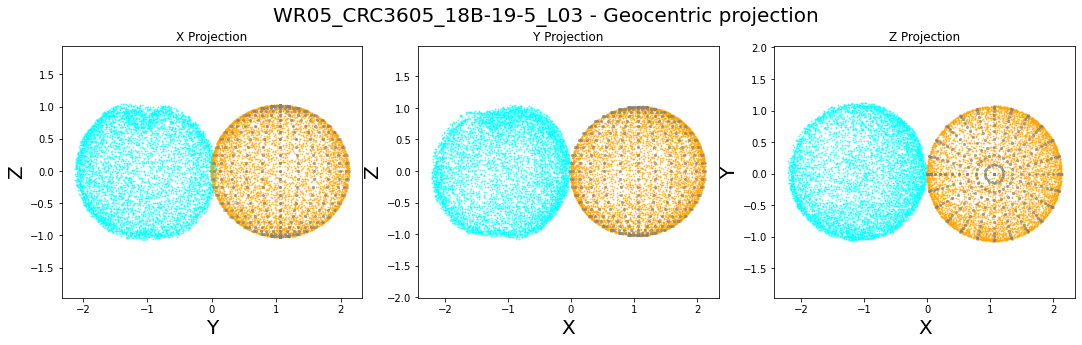

In [12]:
title = bname + '_' + lname + ' - ' + footpoints.title() + ' projection'
markersize = 2
sidestep = np.min(bbox)
alpha = .5
fs = 20

filename = oil_dst + '_'.join(np.array(title.split(' '))[[0,2]])

vitaminC.plot_ell_comparison(cglands, eglands, ecoords, title, sidestep, savefig=savefig, filename=filename)

# References

- **Diaz-Toca, GM**, **Marin, L**, **Necula, I** (2020) Direct transformation from Cartesian into geodetic coordinates on a triaxial ellipsoid. _Computers & Geosciences_ **142**, 104551. [DOI: 10.1016/j.cageo.2020.104551](https://doi.org/10.1016/j.cageo.2020.104551)

- **Li, Q**, **Griffiths, J** (2004) Least squares ellipsoid specific fitting. _Geometric Modeling and Processing. Proceedings, 2004_. 335-340. [DOI: 10.1109/GMAP.2004.1290055](https://doi.org/10.1109/GMAP.2004.1290055)

- **Panou, G**, **Korakitis, R**, **Pantazis, G** (2020) Fitting a triaxial ellipsoid to a geoid model. _Journal of Geodetic Science_ **10**(1), 69-82. [DOI: 10.1515/jogs-2020-0105](https://doi.org/10.1515/jogs-2020-0105)

- **Pewsey, A**, **García-Portugués, E** (2021) Recent advances in directional statistics. _TEST_ **30**(1), 1-58 [DOI: 10.1007/s11749-021-00759-x](https://doi.org/10.1007/s11749-021-00759-x)